# Advances in Machine Learning with Big Data

### (part 1 of 2) 
### Trinity 2020 Weeks 1 - 4
### Dr Jeremy Large
#### jeremy.large@economics.ox.ac.uk


&#169; Jeremy Large ; shared under [CC BY-NC-ND 4.0](https://creativecommons.org/licenses/by-nc-nd/4.0/)

## 2. Being an econometrician *and* a data scientist

## Contents Weeks 1-4:

1. Introducing this course's dataset

1. **Being an econometrician _and_ a data scientist**

1. Data abundance and 'jaggedness' -> regularization and the problem of overfit

1. Regularization through resampling methods (bootstrap etc.)

1. Regularization through predictor/feature selection (Lasso etc.)

1. Moving from linear regression to the perceptron

1. Moving from linear regression to the random forest (and similar)

In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
plt.rcParams['figure.figsize'] = [12, 4]

import sys, os
import logging
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO)

# point at library; I need some lessons on doing good PYTHONPATHs:
REPO_DIR = os.path.dirname(os.getcwd())

UCI_LIB = os.path.join(REPO_DIR, 'lib')
UCI_DATA = os.path.join(REPO_DIR, 'data') 

sys.path.append(UCI_LIB)

UCI_DATA_FILE = os.path.join(UCI_DATA, 'raw.csv') 

from uci_retail_data import stock_codes, uci_files 

Populating the interactive namespace from numpy and matplotlib


### Pull in and prepare our data

In [2]:
if os.path.exists(UCI_DATA_FILE):
    df = uci_files.load_uci_file(UCI_DATA_FILE, uci_files.SHEET_NAME)
else:
    df = uci_files.load_uci_file(uci_files.REMOTE_FILE, uci_files.SHEET_NAME)
    df.to_csv(UCI_DATA_FILE)
    logging.info('Saving a copy to ' + UCI_DATA_FILE)

2020-04-10 16:11:10,049 INFO:Loading C:\Users\jerem\Documents\work\Oxford\SBS\MLBD\ox-sbs-ml-bd\data\raw.csv , sheet Year 2009-2010
2020-04-10 16:11:12,767 INFO:Loaded C:\Users\jerem\Documents\work\Oxford\SBS\MLBD\ox-sbs-ml-bd\data\raw.csv , sheet number one, obviously


Clean data:

In [3]:
# Here, I call the irrelevant lines 'invalids':
invalids = stock_codes.invalid_series(df)

Aggregate into invoices:

In [4]:
invoices = stock_codes.invoice_df(df, invalid_series=invalids)

In [5]:
invoices.head(2)

,customer,codes_in_invoice,items_in_invoice,invoice_spend,hour,month,words,country,words_per_item
Invoice,,,,,,,,,
489434,13085.0,8,166,505.3,7,200912,"{FANCY, STRAWBERRY, HOME, SIZE, BALL, MUG, 7"",...",United Kingdom,3.625
489435,13085.0,4,60,145.8,7,200912,"{BOWL, ,, LARGE, LUNCHBOX, CHASING, CAT, BALL,...",United Kingdom,4.000


In [6]:
invoices.tail(2)

,customer,codes_in_invoice,items_in_invoice,invoice_spend,hour,month,words,country,words_per_item
Invoice,,,,,,,,,
538170,13969.0,25,133,317.59,19,201012,"{UNION, BLUE, SET, HOTTIE, ORANGE, FLAG, VINTA...",United Kingdom,2.92
538171,17530.0,65,194,300.64,20,201012,"{24, DOILIES, BLUE, SET, FLORAL, CHILDRENS, CE...",United Kingdom,2.20


In [7]:
invoices.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20577 entries, 489434 to 538171
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer          18969 non-null  float64
 1   codes_in_invoice  20577 non-null  int64  
 2   items_in_invoice  20577 non-null  int64  
 3   invoice_spend     20577 non-null  float64
 4   hour              20577 non-null  int64  
 5   month             20577 non-null  int64  
 6   words             20577 non-null  object 
 7   country           20577 non-null  object 
 8   words_per_item    20577 non-null  float64
dtypes: float64(3), int64(4), object(2)
memory usage: 1.6+ MB


### Set a prediction problem:

**Given the time, date, and complexity of an invoice, what's its expected spend?**

First, we'll attack this in a familiar way: using, as best we can, *linear regression*. 

*  However, we'll take time to compare two suitable `python` libraries for this.

### 1. [`statsmodels`](https://www.statsmodels.org/stable/index.html)

* package for established statistics; has [some of the feel](https://www.statsmodels.org/stable/example_formulas.html) of R

* *statsmodels: Econometric and statistical modeling with python* Seabold, Skipper, and Josef Perktold. Proceedings of the 9th Python in Science Conference, 2010.

* funded at [Google Summer of Code (GSOC) 2009-2017](https://summerofcode.withgoogle.com/) and by hedge fund [AQR](https://www.aqr.com)      

### 2. [`scikit-learn`](https://scikit-learn.org/stable/index.html)

* package for machine learning

* *Scikit-learn: Machine Learning in Python*, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.

They both do linear regression.

#### Lets import statsmodels / scikit-learn and packages that they use:

In [8]:
import numpy as np    # fast handling of matrices of real numbers, and similar

import pandas as pd     # great tool for wielding and combining rectangular datasets with varied, named, columns



import sklearn

import statsmodels

In [9]:
# in both cases, we will have to import specifically the bits of the package that we need, for example:
import statsmodels.formula.api as smf

#### Reminder of linear regression:

We have an i.i.d. sequence of observations, $\{(y_i, x_i), i=0, 1, ...\}$ where we are interested in moments of the R.V. $y_i$, conditional on the multivariate R.V.  $x_i$ (of length, say, $p$). 

We *postulate* a linear relationship of the following form:

\begin{equation}
y_i = x_i ' \beta + \epsilon_i,
\end{equation}
where $\beta$ is a vector of parameters of length $p$, and the i.i.d. sequence of random variables $\{\epsilon_i\}$ is independent of the regressors $\{x_i\}$

#### A personal story:

Now, what do I mean here by the word: *'postulate'*? 

For the econometrician in me, it means I *sincerely assert*.

For the machine learner in me, I'm not sure that's quite it. It's more that - pragmatically - I entertain this model.

* an important part of this course will be to flesh-out this comparison

### 1. Fitting a linear regression with `statsmodels`

Describe the model in natural statistician's terms:

In [10]:
formula_string = 'np.log(invoice_spend) ~ np.log(codes_in_invoice) + np.log(items_in_invoice) + hour + month + words_per_item'

Specify that the model is OLS:

In [11]:
lm1 = smf.ols(formula=formula_string, data=invoices)

Common, pythonic, step, next, namely to `fit()`:

In [12]:
fit = lm1.fit()

In [13]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     np.log(invoice_spend)   R-squared:                       0.815
Model:                               OLS   Adj. R-squared:                  0.815
Method:                    Least Squares   F-statistic:                 1.813e+04
Date:                   Fri, 10 Apr 2020   Prob (F-statistic):               0.00
Time:                           16:13:33   Log-Likelihood:                -16469.
No. Observations:                  20577   AIC:                         3.295e+04
Df Residuals:                      20571   BIC:                         3.300e+04
Df Model:                              5                                         
Covariance Type:               nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   29.2646     29.005      1.009      0.313     -27.587      86.116
np.log(codes_in_invoice)     0.1440      0.005     31.038      0.000       0.135       0.153
np.log(items_in_invoice)     0.7087      0.003    215.811      0.000       0.702       0.715
hour                        -0.0122      0.002     -7.733      0.000      -0.015      -0.009
month                       -0.0001      0.000     -0.945      0.345      -0.000       0.000
words_per_item               0.0168      0.006      2.691      0.007       0.005       0.029
==============================================================================
Omnibus:                     2692.737   Durbin-Watson:                   1.891
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19904.742
Skew:                           0.405   Prob(JB):                         0.00
Kurtosis:                       7.750   Cond. No.                     1.55e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.55e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The 'condition number' refers to $X'X$ -- and indicates how stably we can expect to invert that matrix

#### Comments on linear regression with `statsmodels`

* Thorough implementation of linear regression, elegant presentation, including tests:
    * significance tests (t-stats, F-tests, p-values, ...)
    * specification tests

* Imagine these tests pass (though they don't here)
    * we may conclude that we now *know* the Data Generating Process
       * our parametric modelling has been successful
    * we understand statistical aspects of the mechanisms out there
    * -> we are in a position to offer *explanations* of past, present and future observation
    

* However, standard reporting from `statsmodels` is in fact **damning** for my specifiation of the linear regression model on this data
    * Message: this is not of use, come back with something that describes reality

* All the data has been used in fitting the regression
    * like e.g. MLEs, resulting estimates are statistically *efficient*.
    * But, to use up all the data like that:
      * was that greedy?
      * was it prudent?

### 2. Fitting a linear regression with `scikit-learn`

In the case of `scikit-learn`, there are preliminaries to go over.

In [14]:
# Reminder of our formulation of this regression:
formula_string

'np.log(invoice_spend) ~ np.log(codes_in_invoice) + np.log(items_in_invoice) + hour + month + words_per_item'

In [15]:
#  First, we'll have to build some additional columns in our dataframe to take account of the logarithms and squaring:
invoices['hour_sqd'] = invoices.hour**2
invoices['log_inv_spend'] = np.log(invoices.invoice_spend)
invoices['log_n_codes'] = np.log(invoices.codes_in_invoice)
invoices['log_n_items'] = np.log(invoices.items_in_invoice)

In [16]:
# Regarding this, set out `y` and `X` variables:
y = pd.DataFrame(invoices['log_inv_spend'])
X = invoices[['log_n_codes', 'log_n_items', 'hour', 'month', 'words_per_item']] # , 'hour_sqd'

In [17]:
#  pull in scikit-learn libraries:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [18]:
model = LinearRegression()

#### `.fit()` - first of two central functions/methods in `scikit-learn`

In [19]:
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

#### `.predict()` - the second of the two

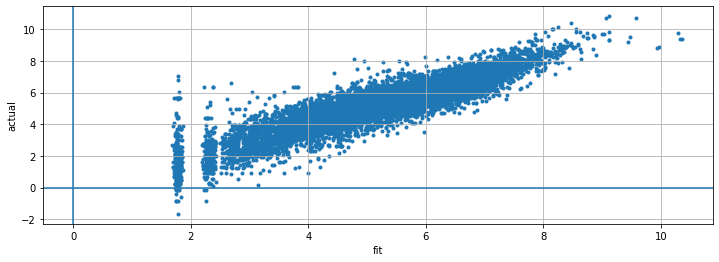

In [20]:
y_hat = model.predict(X)
plt.scatter(y_hat, y, marker='.')
plt.grid(); plt.xlabel('fit'); plt.ylabel('actual'); plt.axvline(); plt.axhline(); plt.show()

In [21]:
print('intercept is ', model.intercept_)
print('coefficients are ', model.coef_)
print('R2 is ', model.score(X, y))

intercept is  [29.26457648]
coefficients are  [[ 1.43967271e-01  7.08724911e-01 -1.22246009e-02 -1.36293685e-04
   1.67567537e-02]]
R2 is  0.8150405334343745


-> We can confirm that these are the same numbers as those obtained earlier with `statsmodels`

#### Observations so far about linear regression with `scikit-learn`

The linear regression feels much less slick than `statsmodels`

* we have to do more work to prepare it

* it only presents the details of its fit, if we interrogate oddly-named attributes like `.coef_`

* it doesn't seem to offer either specification, or significance, testing

In fact, it seems hard to extract from it anything much at all, relating to its *linear* structure



#### Lets push `scikit-learn` harder, to find out where it excels

#### Separate testing data from training data

In [22]:
from sklearn import inspection
from sklearn.model_selection import KFold

Create a function in order to go further:

In [23]:
def train_n_test(X, y, n_folds, verbose=True):
    """
    @param X: rectangle of feature data
    @param y: list or array of target data
    @param n_folds: the number of splits, or folds, of the data that we would like performed
    @param verbose: Boolean. If True, report on intermediate steps
    @return : a list of floats, each is the test R2 from a fold of the data
    """
    
    kfold = KFold(n_splits=n_folds, shuffle=True)
    splits = kfold.split(X, y)    

    scores = []
    for (train, test) in splits:
        
        if verbose or (scores == []):
            print(f"In study {len(scores) + 1}/{n_folds}, {len(test)} datapoints were held back for testing; "
                  f"first 10 such points = {test[:10]}")
            
        reg = LinearRegression()
        reg.fit(X.iloc[train], y.iloc[train])
        
        r2 = metrics.r2_score(                                # r2_score() takes two arguments ...
                              y.iloc[test],                   # the actual targets, and ...                
                              reg.predict(X.iloc[test])       # the fitted targets.
                             )                                # We get a number between 0 and 1 back
        
        scores.append(r2)
    
    return scores


Here's a helper function to plot diagrams:

In [24]:
def mfe_r2_diag(data_array, histogram=False):
    """
    @param data_array: a list or array of quality data from a series of statistical fits
    @param histogram: Boolean. If True, plot a histogram, otherwise plot a scatter of all the data
    @return : nothing
    """
    n = len(data_array)
    if histogram:
        plt.hist(data_array, bins=30)
    else:
        plt.scatter(range(n), data_array, marker='.')
    plt.xlabel(f"The {n} different k-fold splits")
    plt.title("R2, as calculated *only* on the testing datapoints")
    plt.grid()
    plt.axhline(0, color='k')
    plt.show()

#### Now lets deploy `scikit-learn` several times, distinguishing `train` from `test`:

In [25]:
scores = train_n_test(X, y, 6)

In study 1/6, 3430 datapoints were held back for testing; first 10 such points = [ 3 12 25 28 36 38 41 43 47 53]
In study 2/6, 3430 datapoints were held back for testing; first 10 such points = [ 6  9 15 16 21 42 44 49 50 52]
In study 3/6, 3430 datapoints were held back for testing; first 10 such points = [ 0 14 17 22 26 29 31 54 70 74]
In study 4/6, 3429 datapoints were held back for testing; first 10 such points = [23 32 34 39 45 60 61 62 65 79]
In study 5/6, 3429 datapoints were held back for testing; first 10 such points = [ 1  2  4  7 10 13 18 20 24 30]
In study 6/6, 3429 datapoints were held back for testing; first 10 such points = [ 5  8 11 19 27 35 48 59 64 78]


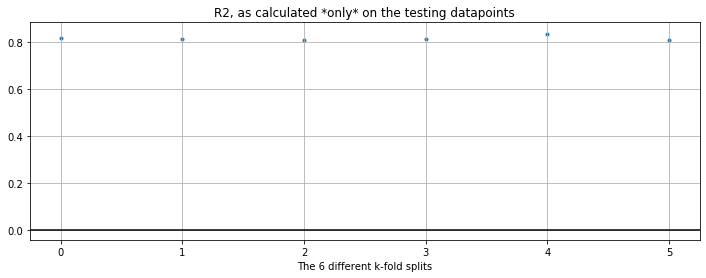

In [26]:
mfe_r2_diag(scores)

In study 1/750, 28 datapoints were held back for testing; first 10 such points = [ 710  790 1172 1596 1977 2210 2470 2591 3139 3398]


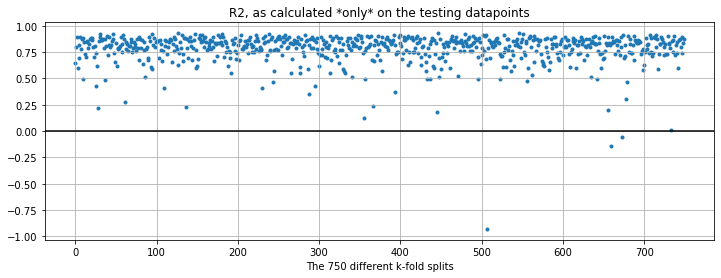

In [30]:
scores = train_n_test(X, y, 750, verbose=False)
mfe_r2_diag(scores)

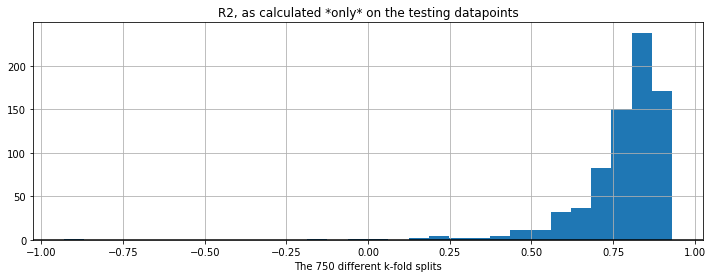

In [31]:
mfe_r2_diag(scores, histogram=True)

In [32]:
f"{np.round(mean(scores), 3)} is only a little less than {np.round(model.score(X, y), 3)}"

'0.782 is only a little less than 0.815'

Mis-specified it may be, but this modelling is working to an R2 of ~80% when applied to 'unseen' data

#### Comments on linear regression with `scikit-learn`

* Correct implementation of linear regression

* Not focused on standard testing for linear regression
    * significance tests (t-stats, F-tests, p-values, ...)
    * specification tests
    

* Our model failed every specification test that `statsmodel` threw at it

* -> YET (per `scikit-learn`): it had a decent r2 on unseen data
    * Pragmatism: this model, for all its faults, can be used
    

* To embody more of a Machine Learning paradigm, we reprioritize:
    * prediction [`.predict() `] as compared to explanation
    * out-of-sample fitting, as compared to specification testing
    * empirical distribution of our statistic, as compared to an asymptotic limit theory for it
    

To embody more of a Machine Learning paradigm, we reprioritize:
* prediction [`.predict() `] as compared to explanation
* out-of-sample fitting, as compared to specification testing
* empirical distribution of our statistic, as compared to an asymptotic limit theory for it

### > In an abundance of data, and for some purposes, this reprioritization will make sense

* leaves us flexible in new dimensions